In [1]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [47]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint


import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import read_sdf, render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionMM2ShapeOpt

seed = 2023
opt = SDFusionMM2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionMM2ShapeOption initialized.


In [26]:
# initialize SDFusion model
ckpt_path = 'saved_ckpt/sdfusion-mm2shape.pth'
opt.init_model_args(ckpt_path=ckpt_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: saved_ckpt/vqvae-snet-all.pth
[*] loading state_dict with strict=False!
[*] resnet18 successfully loaded from https://download.pytorch.org/models/resnet18-f37072fd.pth.
[*] weight successfully load from: saved_ckpt/sdfusion-mm2shape.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusion-Multi-Modal-Conditional-Shape-Generation-Model
[*] "SDFusion-Multi-Modal-Conditional-Shape-Generation-Model" loaded.


/data01/yenchic3/anaconda3/envs/diffsdf-az6/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


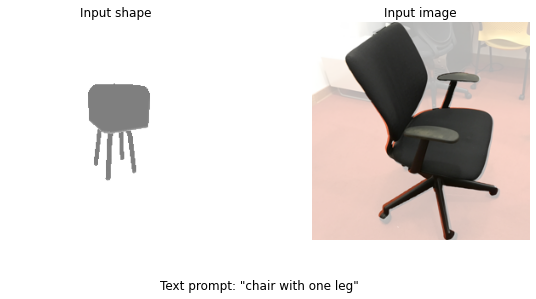

In [66]:
from utils.demo_util import preprocess_image, get_shape_mask, tensor_to_pil
import torchvision.transforms as transforms
# mm2shape
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

# load input shape
sdf_path = 'demo_data/chair-IKEA-FUSION.h5'
sdf = read_sdf(sdf_path)
sdf = sdf.clamp(-.2, .2)

# get partial shape
mask_mode = 'top' # what to keep. check: demo_util.get_shape_mask for other options

# get text
input_txt = "chair with one leg"

# get image
input_img = "demo_data/revolving-chair.jpg"
input_mask = "demo_data/revolving-chair-mask.png"

img_for_vis, img_clean = preprocess_image(input_img, input_mask)
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.Resize((256, 256)),
])
img_clean = transforms(img_clean).unsqueeze(0)

# pack into a dict
test_data = {
    'sdf': sdf,
    'img': img_clean,
    'text': [input_txt],
}

rend_sdf = render_sdf(SDFusion.renderer, sdf.to(device))

# visualize input
# for d in [ tensor_to_pil(rend_sdf), img_for_vis ]:
#     display(d)
# print("text prompt: ", input_txt)

# visualize input
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axis('off')
ax[0].imshow(tensor_to_pil(rend_sdf))
ax[0].title.set_text('Input shape')
ax[1].axis('off')
ax[1].imshow(img_for_vis)
ax[1].title.set_text('Input image')

fig.suptitle(f'Text prompt: "{input_txt}"', y=-0.01)
plt.show()


In [63]:
# inference

# ddim_steps = 100
ddim_steps = 50
ddim_eta = 0.1
uc_scale = 5.

# demo: run four sets of scales
txt_img_scales = [(0., 0.), (1., 0.), (0., 1.), (1., 1.)]

for txt_scale, img_scale in txt_img_scales:
    SDFusion.mm_inference(test_data, mask_mode=mask_mode, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale,
    txt_scale=txt_scale, img_scale=img_scale)
    # save the generation results
    sdf_gen = SDFusion.gen_df
    mesh_gen = sdf_to_mesh(sdf_gen)
    gen_name = f'{out_dir}/mm2shape-gen_shape-txt_{txt_scale}-img_{img_scale}.gif'
    save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

# save input partial shape as well
sdf_part = SDFusion.x_part
mesh_part = sdf_to_mesh(sdf_part)
part_name = f'{out_dir}/mm2shape-part_shape.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_part, nrow=3, out_name=part_name)

[mm inference]: t: 0.0, i:0.0
Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.1
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.36it/s]
/data01/yenchic3/anaconda3/envs/diffsdf-az6/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


[mm inference]: t: 1.0, i:0.0
Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.1
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.35it/s]


[mm inference]: t: 0.0, i:1.0
Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.1
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.29it/s]


[mm inference]: t: 1.0, i:1.0
Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.1
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.29it/s]


Input text: chair with one leg
Input image: 


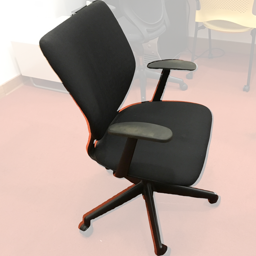

Input partial shape:


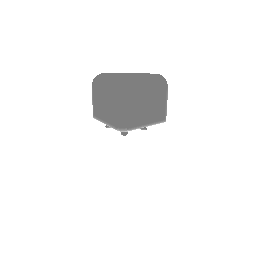

Results (txt strength: 0.0, img strength: 0.0):


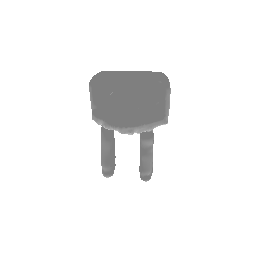

Results (txt strength: 1.0, img strength: 0.0):


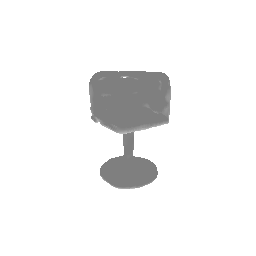

Results (txt strength: 0.0, img strength: 1.0):


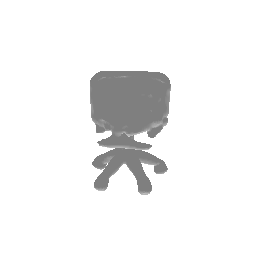

Results (txt strength: 1.0, img strength: 1.0):


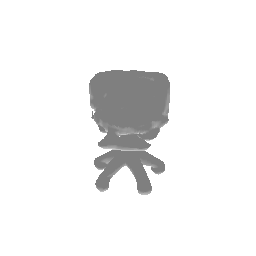

In [64]:
# visualize the results
print(f'Input text: {input_txt}')
print('Input image: ')
display(img_for_vis)
print('Input partial shape:' )
display(ipy_image(part_name))
for txt_scale, img_scale in txt_img_scales:
    print(f'Results (txt strength: {txt_scale}, img strength: {img_scale}):' )
    gen_name = f'{out_dir}/mm2shape-gen_shape-txt_{txt_scale}-img_{img_scale}.gif'
    display(ipy_image(gen_name))